In [34]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis

In [2]:
def fetch_bybit_data(symbol='BTC/USDT', timeframe='5m', limit=1000):
    exchange = ccxt.bybit({
        'options': {'defaultType': 'linear'}  # Required for USDT Perpetuals
    })
    exchange.load_markets()
    
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit, params = {"paginate": True})
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

In [3]:
df = fetch_bybit_data(timeframe='5m', limit=20000)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9990 entries, 2025-03-31 02:00:00 to 2025-05-04 19:10:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    9990 non-null   float64
 1   high    9990 non-null   float64
 2   low     9990 non-null   float64
 3   close   9990 non-null   float64
 4   volume  9990 non-null   float64
dtypes: float64(5)
memory usage: 468.3 KB


In [5]:
# Step 1: Define the slope calculation window (2 hours = 24 bars for 5-min data)
window = 24

threshold = 0.01

# Step 2: Calculate slope (simple rate of change over the window)
df['slope'] = (df['close'].shift(-window) - df['close']) / window

# Step 3: Identify strong slope points
trend_signal = np.select(
    [df['slope'] > threshold, df['slope'] < -threshold],
    [1, -1],
    default=np.nan  # ⚠️ Neutral periods are now NaN
)

# Step 4: Shift the signal backward to label the candle *before* the trend starts
df['label'] = pd.Series(trend_signal, index=df.index).shift(-window)

# Ensure label column only has 1, -1, or NaN
df['label'] = df['label'].where(df['label'].isin([1, -1]))



In [6]:
df['label']

timestamp
2025-03-31 02:00:00    1.0
2025-03-31 02:05:00    1.0
2025-03-31 02:10:00    1.0
2025-03-31 02:15:00    1.0
2025-03-31 02:20:00    1.0
                      ... 
2025-05-04 18:50:00    NaN
2025-05-04 18:55:00    NaN
2025-05-04 19:00:00    NaN
2025-05-04 19:05:00    NaN
2025-05-04 19:10:00    NaN
Name: label, Length: 9990, dtype: float64

In [7]:
fig = go.Figure()

# Price line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['close'],
    mode='lines',
    name='Close Price',
    line=dict(color='black')
))

# Uptrend markers
fig.add_trace(go.Scatter(
    x=df[df['label'] == 1].index,
    y=df[df['label'] == 1]['close'],
    mode='markers',
    name='Uptrend Entry',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Downtrend markers
fig.add_trace(go.Scatter(
    x=df[df['label'] == -1].index,
    y=df[df['label'] == -1]['close'],
    mode='markers',
    name='Downtrend Entry',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

fig.update_layout(
    title="Interactive Slope-Based Trend Labels",
    xaxis_title="Time",
    yaxis_title="Price",
    legend=dict(x=0, y=1),
    height=600
)

fig.show()

In [8]:
# Parameters
window = 24  # 2 hours of 5-minute candles
threshold = 0.03  # slope threshold

# Create label column initialized to NaN
df['label'] = np.nan

# Step through the data in fixed non-overlapping windows
for start in range(0, len(df) - window, window):
    end = start + window
    start_price = df['close'].iloc[start]
    end_price = df['close'].iloc[end]
    slope = (end_price - start_price) / window

    if slope > threshold:
        df.iloc[start, df.columns.get_loc('label')] = 1
    elif slope < -threshold:
        df.iloc[start, df.columns.get_loc('label')] = -1
    # else leave as NaN

# Extract labeled entries for plotting
up = df[df['label'] == 1]
down = df[df['label'] == -1]

# Plot interactively
fig = go.Figure()

# Price line
fig.add_trace(go.Scatter(
    x=df.index, y=df['close'],
    mode='lines', name='Close Price', line=dict(color='black')
))

# Uptrend markers
fig.add_trace(go.Scatter(
    x=up.index, y=up['close'],
    mode='markers', name='Uptrend Entry',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Downtrend markers
fig.add_trace(go.Scatter(
    x=down.index, y=down['close'],
    mode='markers', name='Downtrend Entry',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

fig.update_layout(
    title="Non-Overlapping 2-Hour Slope-Based Labels",
    xaxis_title="Time",
    yaxis_title="Price",
    height=600,
    legend=dict(x=0, y=1)
)

fig.show()

In [9]:
# Drop rows without labels (we only care about labeled ones)
labeled = df[df['label'].notna()].copy()

In [10]:
labeled

,open,high,low,close,volume,slope,label
timestamp,,,,,,,
2025-03-31 02:00:00,81956.2,81979.3,81751.0,81801.6,27.351197,-5.525000,-1.0
2025-03-31 04:00:00,81527.8,81705.2,81522.0,81669.0,14.734315,18.320833,1.0
2025-03-31 06:00:00,82168.6,82275.6,82090.9,82108.7,16.213517,0.900000,1.0
2025-03-31 08:00:00,81942.7,82147.4,81917.3,82130.3,84.896195,-22.516667,-1.0
2025-03-31 10:00:00,81455.9,81590.0,81441.2,81589.9,27.271978,22.920833,1.0
...,...,...,...,...,...,...,...
2025-05-04 08:45:00,95622.7,95691.8,95538.2,95679.0,28.123324,-10.620833,-1.0
2025-05-04 10:45:00,95488.9,95532.0,95424.0,95424.1,12.991745,7.170833,1.0
2025-05-04 12:45:00,95527.6,95596.2,95525.9,95596.2,16.623380,-0.879167,-1.0


In [11]:
# Step 1: Shift to compare with the previous label
labeled['prev_label'] = labeled['label'].shift(1)

In [12]:
labeled_filtered = labeled[labeled['label'] != labeled['prev_label']].copy()

In [42]:
labeled_filtered['log_return'] = np.log(labeled_filtered.close/labeled_filtered.close.shift(1))

In [51]:
labeled_filtered['realized_pnl'] = labeled_filtered['label'].shift(1) * labeled_filtered['log_return']
labeled_filtered['realized_pnl'].sum()

np.float64(1.9418347645010883)

In [52]:
labeled_filtered

,open,high,low,close,volume,slope,label,prev_label,log_return,realized_pnl
timestamp,,,,,,,,,,
2025-03-31 02:00:00,81956.2,81979.3,81751.0,81801.6,27.351197,-5.525000,-1.0,NaN,NaN,NaN
2025-03-31 04:00:00,81527.8,81705.2,81522.0,81669.0,14.734315,18.320833,1.0,-1.0,-0.001622,0.001622
2025-03-31 08:00:00,81942.7,82147.4,81917.3,82130.3,84.896195,-22.516667,-1.0,1.0,0.005633,0.005633
2025-03-31 10:00:00,81455.9,81590.0,81441.2,81589.9,27.271978,22.920833,1.0,-1.0,-0.006602,0.006602
2025-03-31 16:00:00,83420.5,83693.6,83420.5,83635.2,23.026791,-31.179167,-1.0,1.0,0.024759,0.024759
...,...,...,...,...,...,...,...,...,...,...
2025-05-04 04:45:00,95764.5,95858.7,95739.8,95770.9,10.052617,8.341667,1.0,-1.0,-0.000780,0.000780
2025-05-04 06:45:00,95917.8,95981.7,95917.8,95971.1,8.466981,-12.170833,-1.0,1.0,0.002088,0.002088
2025-05-04 10:45:00,95488.9,95532.0,95424.0,95424.1,12.991745,7.170833,1.0,-1.0,-0.005716,0.005716


In [24]:
df['label_filtered'] = np.nan
df.loc[labeled_filtered.index, 'label_filtered'] = labeled_filtered['label']

df.loc[labeled_filtered.index, 'log_return'] = labeled_filtered['log_return']

In [ ]:
returns = labeled_filtered['log_return'].dropna()

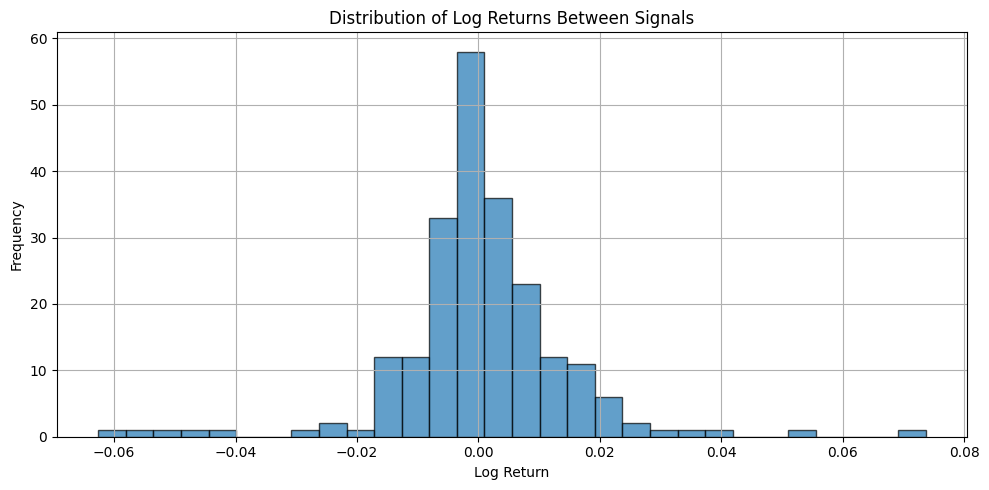

In [33]:
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(returns, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Log Returns Between Signals")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
stats = {
    "mean": returns.mean(),
    "std_dev": returns.std(),
    "skewness": skew(returns),
    "kurtosis": kurtosis(returns),  # excess kurtosis
    "sharpe_ratio": returns.mean() / returns.std(),
    "median": returns.median(),
    "min": returns.min(),
    "max": returns.max()
}
stats_df = pd.DataFrame(stats, index=["Log Return Stats"]).T
stats_df

,Log Return Stats
mean,0.000698
std_dev,0.014158
skewness,-0.027937
kurtosis,6.905868
sharpe_ratio,0.049267
median,-0.000171
min,-0.062610
max,0.073688


In [28]:
df.tail()


,open,high,low,close,volume,slope,label,label_filtered,log_return,realized_pnl
timestamp,,,,,,,,,,
2025-05-04 18:50:00,95390.4,95433.5,95375.1,95433.4,4.384421,NaN,NaN,NaN,NaN,NaN
2025-05-04 18:55:00,95433.4,95476.2,95373.6,95373.6,22.212386,NaN,NaN,NaN,NaN,NaN
2025-05-04 19:00:00,95373.6,95390.2,95336.9,95390.2,12.272528,NaN,NaN,NaN,NaN,NaN
2025-05-04 19:05:00,95390.2,95438.0,95390.2,95437.9,6.235507,NaN,NaN,NaN,NaN,NaN
2025-05-04 19:10:00,95437.9,95446.2,95418.2,95432.4,6.461161,NaN,NaN,NaN,NaN,NaN


In [29]:
df.label.value_counts()

label
-1.0    211
 1.0    205
Name: count, dtype: int64

timestamp
2025-03-31 02:00:00   NaN
2025-03-31 02:05:00   NaN
2025-03-31 02:10:00   NaN
2025-03-31 02:15:00   NaN
2025-03-31 02:20:00   NaN
                       ..
2025-05-04 18:50:00   NaN
2025-05-04 18:55:00   NaN
2025-05-04 19:00:00   NaN
2025-05-04 19:05:00   NaN
2025-05-04 19:10:00   NaN
Name: log_return, Length: 9990, dtype: float64

In [17]:
# Prepare filtered markers
up_filtered = df[df['label_filtered'] == 1]
down_filtered = df[df['label_filtered'] == -1]

# Plot interactive version
fig = go.Figure()

# Price line
fig.add_trace(go.Scatter(
    x=df.index, y=df['close'],
    mode='lines', name='Close Price', line=dict(color='black')
))

# Filtered uptrend markers
fig.add_trace(go.Scatter(
    x=up_filtered.index, y=up_filtered['close'],
    mode='markers', name='Uptrend Entry',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Filtered downtrend markers
fig.add_trace(go.Scatter(
    x=down_filtered.index, y=down_filtered['close'],
    mode='markers', name='Downtrend Entry',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

fig.update_layout(
    title="De-duplicated Trend Labels: One Entry Per Regime",
    xaxis_title="Time",
    yaxis_title="Price",
    height=600,
    legend=dict(x=0, y=1)
)

fig.show()

NameError: name 'r' is not defined